In [206]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker as mtick
import matplotlib.cm as cm
import math
import plotly.graph_objects as go
from collections import OrderedDict
from matplotlib.lines import Line2D  # Import for creating custom legend markers
import json
import copy
import random
import re
import seaborn as sns
import importlib


# Import BW25 packages
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import bw2analyzer as bwa
import brightway2 as bw 
from bw2calc import LeastSquaresLCA

In [207]:
from  standards import *
import Monte_Carlo as MC
import life_cycle_assessment as lc


importlib.reload(MC)

importlib.reload(lc)

Folder name Results created


<module 'life_cycle_assessment' from 'c:\\Users\\ruw\\Desktop\\RA\\Single-use-vs-multi-use-in-health-care\\Brighway\\life_cycle_assessment.py'>

In [208]:
save_dir = results_folder('Results')

file_name = r'Results\Ananas - CONSQ.xlsx'
file_cont_name = r'Results\Ananas contribution - CONSQ.xlsx'
sheet_name = 'Ananas'

path = r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Brighway'

# Your name variable should be the name of the project.
database_project = "RA - Ofir & Stine 1"
database_name = "Ananas consq"

flows = ['alubox - CONSQ', 'PP sheet sc2 - CONSQ', 'PP sheet sc3 - CONSQ']
flow_legend = ['alubox - CONSQ sc1', 'PP sheet sc2 - CONSQ', 'PP sheet sc3 - CONSQ']


Folder name Results created


In [209]:
FU, FU_proc, impact_category, plot_x_axis, sub_product_details = lc.LCA_initialization(database_project, database_name, flows)
impat =  impact_category

calculate = True

if f'{path}\{sheet_name}' is False or calculate is True:
    # Caculating the LCA results
    df = lc.life_cycle_impact_assessment(flows, FU, impat, FU_proc)
    lc.save_LCA_results(df, file_name, sheet_name, impat)


df_test = lc.import_LCA_results(file_name, flows, impat)

Biosphere database already present!!! No setup is needed
Initialization is completed

Calculating the LCA results:
Calculation 1 of 480 {'alubox raw materials - CONSQ' (unit, GLO, None): 0.002} acidification 0.0009945931379257335
Calculation 2 of 480 {'alubox production - CONSQ' (unit, GLO, None): 0.002} acidification 9.762607525302666e-05
Calculation 3 of 480 {'autoclave - CONSQ' (unit, GLO, None): 0.1111111111111111} acidification 0.0014014285477584704
Calculation 4 of 480 {'Handwash - CONSQ' (unit, GLO, None): 1} acidification 0.00013896506335219004
Calculation 5 of 480 {'alubox EoL melting - CONSQ' (unit, GLO, None): -0.002} acidification 0.000863221102818143
Calculation 6 of 480 {'alubox EoL mixed sorting - CONSQ' (unit, GLO, None): -0.002} acidification 1.310251360070705e-05
Calculation 7 of 480 {'transport Alu - CONSQ' (unit, GLO, None): 1} acidification 5.1128321049625e-06
Calculation 8 of 480 {'avoided alubox raw materials - CONSQ' (unit, GLO, None): -0.002} acidification -0.0

In [210]:
# # Processing the LCA results
sub_proccess, amount = lc.obtaining_sub_process(sub_product_details)
FU_sub, FU_sub_proc, idx = lc.sub_process_initilization(sub_proccess, FU, database_project, 'df_idx_ofir')
flow_count, flow_sub, functional_unit_sub = lc.FU_contibution_initilization(FU_sub, FU_sub_proc)


Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initiali

In [211]:
fu_sub_updated = lc.process_update(FU, functional_unit_sub)
# functional_unit_sub_new[1]


In [166]:
df_cont = lc.LCIA_contribution(impat, flow_count, FU_sub_proc, fu_sub_updated, amount, idx)

Processing flow: alubox raw materials - CONSQ in impact category: acidification
'market for aluminium, wrought alloy' (kilogram, GLO, None) Calculation 1 of 2464, Score: 0.0009462506502292941 acidification
'steel production, chromium steel 18/8, hot rolled' (kilogram, RER, None) Calculation 2 of 2464, Score: 4.8342486733289286e-05 acidification
row : 0, col : 0 is assigned list : [["'market for aluminium, wrought alloy' (kilogram, GLO, None)", 0.0009462506502292941], ["'steel production, chromium steel 18/8, hot rolled' (kilogram, RER, None)", 4.8342486733289286e-05]]
Processing flow: alubox production - CONSQ in impact category: acidification
'anodising, aluminium sheet' (square meter, RER, None) Calculation 3 of 2464, Score: 3.220412209720347e-05 acidification
'impact extrusion of aluminium, 4 strokes' (kilogram, RER, None) Calculation 4 of 2464, Score: 2.6803678273025643e-05 acidification
'corrugated board box production' (kilogram, RER, None) Calculation 5 of 2464, Score: 9.5840180

In [167]:
lc.save_LCA_results(df_cont, file_cont_name, sheet_name, impat)

DataFrame with nested lists written to Excel successfully.


In [168]:
df_c = lc.import_LCA_results(file_cont_name, idx, impact_category)

alubox raw materials - CONSQ - sc 1
["'market for aluminium, wrought alloy' (kilogram, GLO, None)", 0.14408880803499768]
["'steel production, chromium steel 18/8, hot rolled' (kilogram, RER, None)", 0.010155120108550885]
alubox production - CONSQ - sc 1
["'anodising, aluminium sheet' (square meter, RER, None)", 0.004144322364812754]
["'impact extrusion of aluminium, 4 strokes' (kilogram, RER, None)", 0.009568673158897143]
["'corrugated board box production' (kilogram, RER, None)", -0.00027635242720411903]
["'metal working, average for chromium steel product manufacturing' (kilogram, RER, None)", 0.00396528934943966]
["'polystyrene foam slab production' (kilogram, RER, None)", 0.0]
["'section bar extrusion, aluminium' (kilogram, RER, None)", 0.0]
["'sheet rolling, aluminium' (kilogram, RER, None)", 0.004754841606873683]
autoclave - CONSQ - sc 1
["'autoclave - CONSQ' (unit, GLO, None)", 0.014801466839460474]
disinfection - CONSQ - sc 1
["'disinfection - CONSQ' (unit, GLO, None)", 0.00995

[2, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [252]:
df_tot, df_scaled, df_cols = lc.dataframe_element_scaling(df_test)
index_list = list(df_scaled.index.values)
plt_leg = lc.dataframe_column_structure(impat)

In [253]:
df_GWP = df_test[df_test.columns[1]].to_frame()
df_GWP

,EF v3.1 EN15804
,climate change
,global warming potential (GWP100)
alubox - CONSQ,"[[alubox raw materials - CONSQ, 0.154243928228..."
PP sheet sc2 - CONSQ,"[[pp production - CONSQ, 0.22940403948446897],..."
PP sheet sc3 - CONSQ,"[[pp production - CONSQ, 0.22940403948446897],..."


In [378]:
x_axis = []
GWP_value = []

# gwp_tot = [0] * len(df_updated)
for df_size in range(len(df_GWP)):
    lst_x = []
    lst_GWP = []
    gwp_tot = 0
    for key in df_GWP.keys():
        for lst_size in range(len(df_GWP[key][df_size])):
            #print(df_size, lst_size)
            x = df_GWP[key][df_size][lst_size][0]
            gwp = df_GWP[key][df_size][lst_size][1]
            
            #print(gwp,x)
            if '- CONSQ' in x:
                #print(key)
                x = x.replace(f' - CONSQ', '')
            if 'alubox' in x:           
                x = x.replace('alubox ', '')
                if 'raw' in x and 'avoid' not in x.lower():
                    x = x.replace('raw materials', 'Raw mat.')
                elif 'raw' in x and 'avoid' in x:
                    x = 'Avoided virgin mat.'
                if 'production' in x:
                    x = 'Production'
            if 'Waste' in x:
                x = 'Incineration'
                
            if 'market for electricity' in x:
                x = 'Avoided electricity'
            if 'heating' in x:
                x = 'Avoided heat'
            if 'market for polypropylene' in x:
                x = 'PP granulate'
            if 'PE granulate' in x:
                x = 'PE granulate'
            if 'no Energy Recovery' in x:
                x = x.replace(' no Energy Recovery', '')
                print(x)
                gwp = - gwp
            if 'board box' in x:
                x = 'Cardboard box'
            if 'packaging film' in x:
                x = 'PE packaging film prod.'
            if 'pp' in x:
                x = x.replace('pp', 'PP')
            if 'autoclave' in x:
                x = x.replace('autoclave', 'Autoclave')
            if 'transport' in x:
                x = 'Transport'

            lst_x.append(x)
            lst_GWP.append(gwp)
            gwp_tot += gwp
    # print(gwp_tot, lst_GWP)
    lst_GWP.append(gwp_tot)
    lst_x.append('Total')
    x_axis.append(lst_x)
    GWP_value.append(lst_GWP)



PE incineration
PP incineration
PE incineration
PP incineration


C:\Users\ruw\AppData\Local\Temp\8\ipykernel_20380\1190330651.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for lst_size in range(len(df_GWP[key][df_size])):
C:\Users\ruw\AppData\Local\Temp\8\ipykernel_20380\1190330651.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = df_GWP[key][df_size][lst_size][0]
C:\Users\ruw\AppData\Local\Temp\8\ipykernel_20380\1190330651.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gwp = 

In [365]:
for x in GWP_value:
    # print(x)
    temp_val = 0
    for y in x:
        if y != x[-1]:
            temp_val += y
    print(temp_val, x[-1]) 

0.3258906089115956 0.3258906089115956
0.7193984770556713 0.7193984770556713
0.5610099316009893 0.5610099316009893


0.3258906089115956

In [416]:
# Categories definitions
categories = ["Raw mat. + prod.", "Use", "Transport", "EoL", "Total"]
category_mapping = {
    "Raw mat. + prod.": ["PP production", "Cardboard box", "Scalpel", "Raw mat.", "Production"],
    "Use": ["Autoclave", "disinfection", "Handwash", "Remanufacturing"],
    "Transport": ["Transport"],
    "EoL": ["PP incineration", "PE incineration", "Avoided heat", "Avoided electricity", "EoL melting", "EoL mixed sorting", "Avoided virgin mat."],
    "Total": ["Total"]
}

# Ensure the legend displays items in the category order
ordered_legend = {key: [] for key in category_mapping}

for x_lst in range(len(x_axis)):
    for x in range(len(x_axis[x_lst])):
        
        for key, item in category_mapping.items():
                # print(x_axis[x_lst][x], item, x_axis[x_lst][x] in item)
                if x_axis[x_lst][x] in item:
                    # print(x_axis[x_lst][x], item, x_lst, x)
                    ordered_legend[key].append(x_axis[x_lst][x])

plot_legend = {key: [] for key in category_mapping}
temp = []

for key,value in ordered_legend.items():
    #print(key, value)
    for val in value:
        if val not in temp:
            temp.append(val)
            # print(val)
            plot_legend[key].append(val)


colors = plot_colors(temp,'turbo')


In [417]:
columns_to_plot = df_scaled.columns

In [418]:
plt_leg = lc.dataframe_column_structure(impact_category)


In [419]:
len(df_scaled)

3

In [420]:
def round_down(value):
    # https://stackoverflow.com/questions/41383787/round-down-to-2-decimal-in-python
    value = math.floor(value * 10)/10.0
    return value

In [421]:
round_down(-1.43)

-1.5

-0.3632748853499619
-1.451412220432904
0.35520174279675715


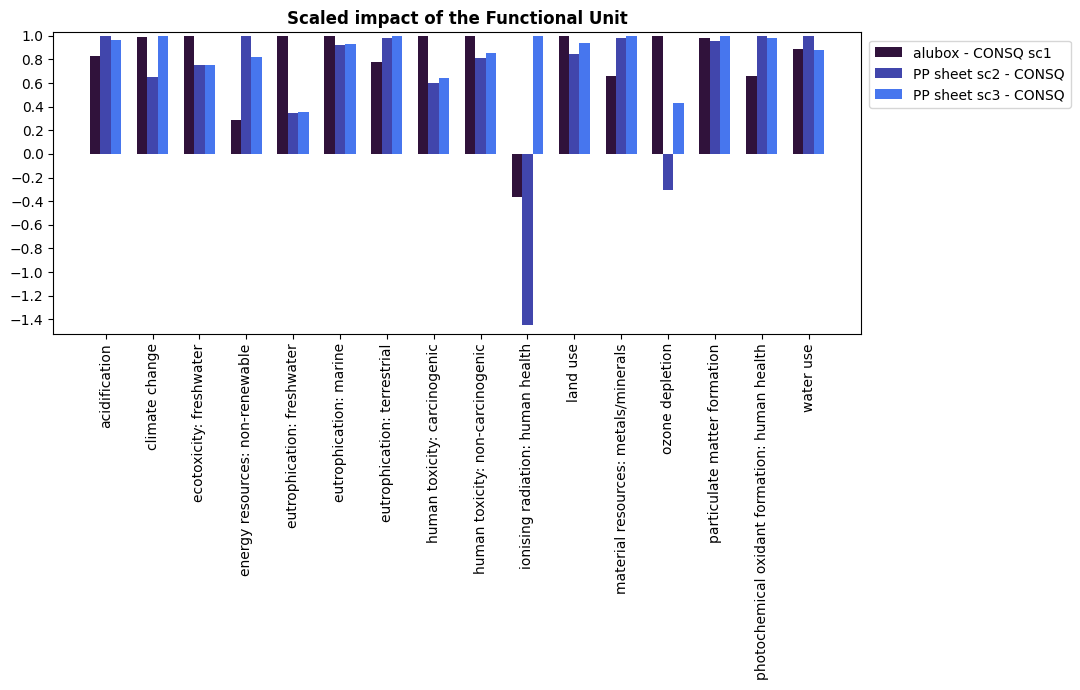

In [422]:
# Plotting
fig, ax = plt.subplots(figsize=(9,7))

num_processes = len(df_scaled)
bar_width = 1/(len(index_list) + 1.5) 
index = np.arange(len(columns_to_plot))

# Plotting each group of bars
min_val = 0
for i, process in enumerate(df_scaled.index):
    values = df_scaled.loc[process, columns_to_plot].values
    ax.bar((index + i * bar_width), values, bar_width, label=process, color=colors[i])  
    print(min(values))
    if min_val > min(values):
        min_val = min(values)


# Setting labels and title
ax.set_title('Scaled impact of the Functional Unit',weight='bold')
ax.set_xticks(index + bar_width )
ax.set_xticklabels(plot_x_axis)
plt.xticks(rotation=90)
plt.yticks(np.arange(-1.6, 1.01, step=0.2))
plt.ylim(-1.52,1.03)

ax.legend(flow_legend,bbox_to_anchor=(1.01, .75, .25, 0), loc="lower left",
            mode="expand", borderaxespad=0,  ncol=1)
plt.tight_layout()
# plt.savefig(os.path.join(save_dir, img_res), bbox_inches='tight')
plt.show()

In [423]:
directory = 'C:\\Users\\ruw\\Desktop\\RA\\'
lst_scaled = lc.LCIA_normalization(directory, df_tot)

In [424]:
lst_scaled

[0.804227007232869, 0.9944742060614233, 1.0]

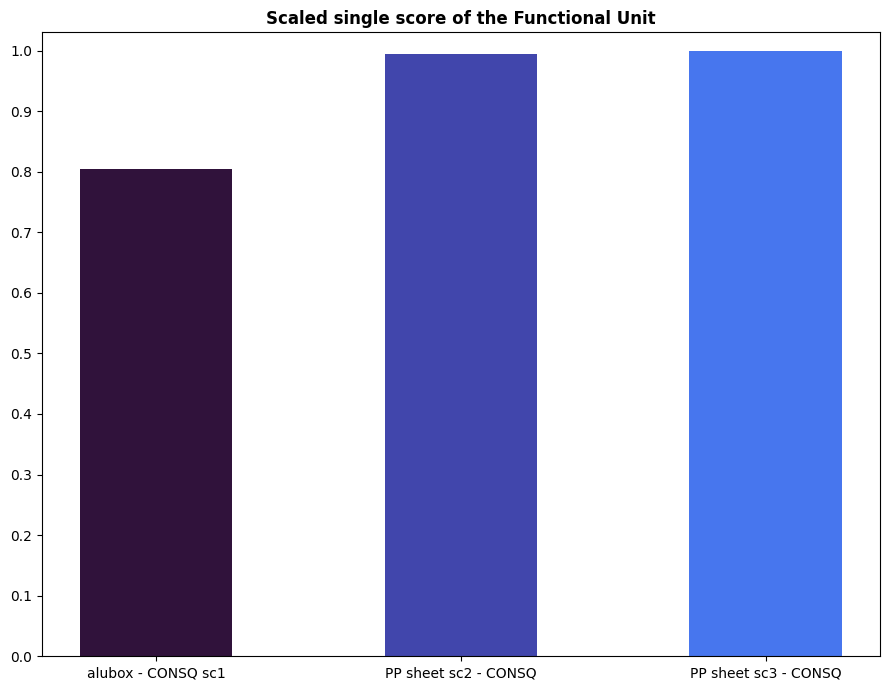

In [425]:
# Plotting
fig, ax = plt.subplots(figsize=(9,7))

num_processes = len(lst_scaled)
bar_width = 1/(len(index_list)-1) 
index = np.arange(len(index_list))   

ax.bar(index + bar_width, lst_scaled, bar_width, label=index_list, color=colors)

# Setting labels and title
ax.set_title('Scaled single score of the Functional Unit',weight='bold')
ax.set_xticks(index + bar_width )
ax.set_xticklabels(flow_legend)
#plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.01, step=0.1))
plt.ylim(0,1.03)

plt.tight_layout()
# plt.savefig(os.path.join(save_dir, img_res), bbox_inches='tight')
plt.show()

In [426]:
# # Categories definitions
# categories = ["Raw mat. + prod.", "Use", "Transport", "EoL", "Total"]
# category_mapping = {
#     "Raw mat. + prod.": ["Diathermy", "Bipolar burner", "Scalpel"],
#     "Use": ["Autoclave", "Dishwasher", "Erbe", "Remanufacturing"],
#     "Transport": ["Transport"],
#     "EoL": ["Incineration", "Avoided heat", "Avoided electricity"],
#     "Total": ["Total"]
# }

# Ensure the legend displays items in the category order
ordered_legend = {key: [] for key in category_mapping}

for x_lst in range(len(x_axis)):
    for x in range(len(x_axis[x_lst])):
        
        for key, item in category_mapping.items():
                #print(x_axis[x_lst][x], item, x_axis[x_lst][x] in item)
                if x_axis[x_lst][x] in item:
                    # print(x_axis[x_lst][x], item, x_lst, x)
                    ordered_legend[key].append(x_axis[x_lst][x])

plot_legend = {key: [] for key in category_mapping}
temp = []

for key,value in ordered_legend.items():
    #print(key, value)
    for val in value:
        if val not in temp:
            temp.append(val)
            # print(val)
            plot_legend[key].append(val)



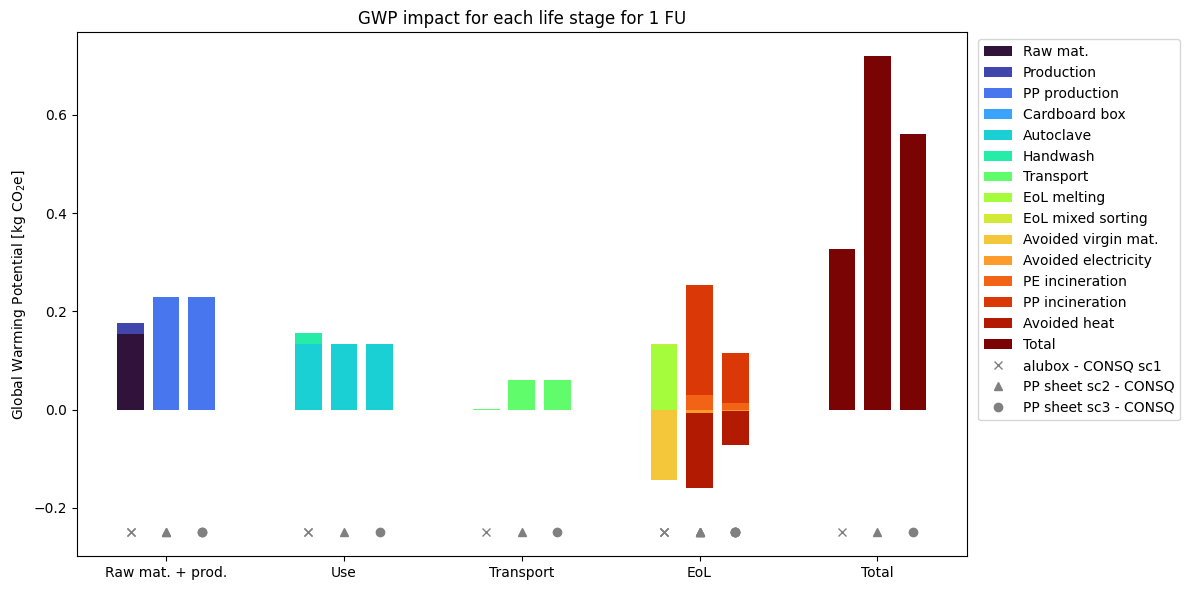

In [427]:

color_map = {}
#unique_processes = {process for sublist in x_axis for process in sublist}
for i, process in enumerate(temp):
    color_map[process] = colors[i]
    #print(process, i)



# Initialize an ordered dictionary for legend_handles to maintain the order
legend_handles = OrderedDict()

# Initialize legend_handles with keys from plot_legend and empty lists
for process in temp:
    legend_handles[process] = None

# Plotting logic
if len(x_axis) == len(GWP_value):
    num_scenarios = len(GWP_value)  # Number of scenarios
    bar_width = 0.15  # Width of the bars for each scenario
    space_between_scenarios = 0.05  # Space between each scenario set
    index = np.arange(len(categories))  # X-axis index positions for the categories

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    idx = ['x', '^', 'o']  # List of markers for scenarios
    all_markers = []  # List to store Line2D objects for markers

    # Main plotting logic
    for scenario in range(num_scenarios):
        bottom_positive = np.zeros(len(categories))  # Initialize the bottom array for positive values
        bottom_negative = np.zeros(len(categories))  # Initialize the bottom array for negative values
        scenario_index = index + scenario * (bar_width + space_between_scenarios)

        for length in range(len(x_axis[scenario])):
            process_name = x_axis[scenario][length]
            value = GWP_value[scenario][length]

            # Determine which category this process falls into
            for i, category in enumerate(categories):
                if any(keyword in process_name for keyword in category_mapping[category]):
                    # Assign color based on the process name
                    color = color_map[process_name]

                    # Create a bar with the specific color
                    if value >= 0:
                        bar = ax.bar(scenario_index[i], value, bar_width,
                                    label=f"{process_name}" if legend_handles[process_name] is None else "",
                                    bottom=bottom_positive[i],
                                    color=color)
                        bottom_positive[i] += value
                    else:
                        bar = ax.bar(scenario_index[i], value, bar_width,
                                    label=f"{process_name}" if legend_handles[process_name] is None else "",
                                    bottom=bottom_negative[i],
                                    color=color)
                        bottom_negative[i] += value

                    # Add the bar to the corresponding process in legend_handles
                    if legend_handles[process_name] is None:
                        legend_handles[process_name] = bar

                    # Add plot markers (symbols) at the bottom
                    ax.plot(scenario_index[i], -0.25, marker=idx[scenario], color='gray')

                    break

    # Add custom markers to the legend
    for i, marker in enumerate(idx):
        all_markers.append(Line2D([0], [0], marker=marker, color='gray', label=f'Scenario {i + 1}', linestyle='None'))

    # Set x-axis labels and ticks, adjusting to account for spacing
    tick_positions = index + (num_scenarios - 1) * (bar_width + space_between_scenarios) / 2
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(categories)

    # Axis limits
    # ax.set_ylim(-.45, 3.55)
    # ax.set_yticks(np.arange(-0.5, 3.6, step=0.25))
    ax.set_ylabel("Global Warming Potential [kg CO$_2$e]")
    ax.set_title('GWP impact for each life stage for 1 FU')

    # Add markers to legend_handles for display at the bottom of the legend
    valid_legend_handles = [(k, v) for k, v in legend_handles.items() if v is not None]
    legend_handles_for_display = valid_legend_handles + [(flow_legend[i], marker) for i, marker in enumerate(all_markers)]

    if legend_handles_for_display:
        ax.legend(handles=[v for k, v in legend_handles_for_display], labels=[k for k, v in legend_handles_for_display], bbox_to_anchor=(1.005, 1), loc='upper left')

    plt.tight_layout()
    #plt.savefig(os.path.join(save_dir, f'LC_impact_ofir_APOS.jpg'), bbox_inches='tight')
    plt.show()
    

else:
    print('The x-axis and GWP values have different sizes')


In [633]:
df_c_gwp =df_c[[df_c.columns[1]]]
c = []

node_sc1 = ['Raw material','Production', 'Use', 'EoL']
node_sc2 = []
node_sc3 = []

links_sc1 = []
links_sc2 = []
links_sc3 = []
# for i, node in enumerate(df_c_gwp):
#     print(i, node)
# for node in range(len(nodes)):

rm = 0
prod = 0
use = 0
eol = 0

for i, row in df_c_gwp.iterrows():
    # print(i,  'sc 1' in i)
    # print(i,  'sc 2' in i)
    # print(i,  'sc 3' in i)
    
    if 'sc 1' in i:
        # print(i)
        print(i)
        node_sc1.append(i)
    # elif 'sc 2' in i:
    #     node_sc2.append(i)
    # else:
    #     node_sc3.append(i)
    
    # print(i)



        for element in row:

            # c.append(len(element))
            for proc in element:
                source = proc[0]
                val = proc[1]/GWP_value[0][-1]*100

                if  val < 0:
                    # print(proc[0])
                    source += ' --'
                    val *= -1
                if 'raw material' in i:
                    dct_temp = {"source": source, "target": 'Raw material', "value":val}
                    rm += proc[1]
                elif 'production' in i:
                    dct_temp = {"source": source, "target": 'Production', "value": val}
                    prod += proc[1]
                elif 'autoclave' in i.lower() or 'handwash' in i.lower() or 'transport' in i.lower():
                    dct_temp = {"source": source, "target": 'Use', "value": val}
                    use += proc[1]
                elif 'eol' in i.lower():
                    dct_temp = {"source": source, "target": 'EoL', "value": val}
                    eol += proc[1]

                links_sc1.append(dct_temp)
                node_sc1.append(source)
                # if 'sc 1' in i:
                #     # print(i)
                #     links_sc1.append(dct_temp)
                #     node_sc1.append(proc[0])
                # elif 'sc 2' in i:
                #     links_sc2.append(dct_temp)
                #     node_sc2.append(proc[0])
                # else:
                #     links_sc3.append(dct_temp)
                #     node_sc3.append(proc[0])

links_sc1.append({"source": 'Raw material', "target": 'Production', "value":rm})
links_sc1.append({"source": "Production", "target": 'Use', "value": prod})
links_sc1.append({"source": "Use", "target": 'EoL', "value": use})
# dct_temp = {"source": source, "target": 'EoL', "value": val}

alubox raw materials - CONSQ - sc 1
alubox production - CONSQ - sc 1
autoclave - CONSQ - sc 1
disinfection - CONSQ - sc 1
Handwash - CONSQ - sc 1
alubox EoL melting - CONSQ - sc 1
alubox EoL mixed sorting - CONSQ - sc 1
transport Alu - CONSQ - sc 1


In [631]:
# for plc, node in enumerate(node_sc1):
#     # print(node)
#     if '- CONSQ - sc 1' in node:
#         node_sc1[plc] = node.replace(f' - CONSQ - sc 1', '')
#     elif 'wrought alloy' in node:
#         node_sc1[plc] = 'Virgin alu'
#     elif 'steel production' in node:
#         node_sc1[plc] = 'Virgin steel'
#     elif 'impact extrusio' in node:
#         node_sc1[plc] = 'Alu impact extrusion'
#     elif 'corrugated' in node:
#         node_sc1[plc] = 'Cardboard box'
#     elif 'anodising' in node:
#         node_sc1[plc] = 'Alu anodising'
#     elif 'transport' in node:
#         node_sc1[plc] = 'Transport '
# node_sc1

['Raw material',
 'Production',
 'Use',
 'EoL',
 'alubox raw materials',
 'Virgin alu',
 'Virgin steel',
 'alubox production',
 'Alu anodising',
 'Alu impact extrusion',
 'Cardboard box',
 "'metal working, average for chromium steel product manufacturing' (kilogram, RER, None)",
 "'polystyrene foam slab production' (kilogram, RER, None)",
 "'section bar extrusion, aluminium' (kilogram, RER, None)",
 "'sheet rolling, aluminium' (kilogram, RER, None)",
 'autoclave',
 "'autoclave - CONSQ' (unit, GLO, None)",
 'disinfection',
 "'disinfection - CONSQ' (unit, GLO, None)",
 'Handwash',
 "'Handwash - CONSQ' (unit, GLO, None)",
 'alubox EoL melting',
 "'treatment of metal scrap, mixed, for recycling, unsorted, sorting' (kilogram, Europe without Switzerland, None) --",
 'alubox EoL mixed sorting',
 "'treatment of metal scrap, mixed, for recycling, unsorted, sorting' (kilogram, Europe without Switzerland, None) --",
 'Transport ',
 'Transport ']

In [634]:
# Create a Sankey diagram
fig = go.Figure()

# Calculate the scale factor for link thickness and node size
max_value = 175.14  # max(link['value'] for link in links)
scale_factor = 1  # You can adjust this factor to control the scaling

# Calculate total outflow for each node and round to 2 decimals
outflow_totals = {node: round(sum(link['value'] for link in links_sc1 if link['source'] == node), 2) for node in node_sc1}

# Calculate total inflow for each node and round to 2 decimals
inflow_totals = {node: round(sum(link['value'] for link in links_sc1 if link['target'] == node), 2) for node in node_sc1}

# Determine if a node has only incoming flows
incoming_only = {node: inflow_totals[node] > 0 and outflow_totals[node] == 0 for node in node_sc1}

# Calculate y-coordinates for nodes based on total outflow or inflow
node_y_coordinates = [sum(inflow_totals[node] if incoming_only[node] else outflow_totals[node] for node in node_sc1[:i]) for i in range(len(node_sc1))]

# Add links
fig.add_trace(go.Sankey(
    node=dict(
        pad=500,
        thickness=20,
        line=dict(width=[link['value'] / max_value * scale_factor for link in links_sc1]),
        label=[f"{node}<br>{inflow_totals[node] if incoming_only[node] else outflow_totals[node]}%" for node in node_sc1],
        #color=[node_colors.get(node, 'rgba(255, 255, 255, {})') for node in node_sc1],
    ),
    link=dict(
        source=[node_sc1.index(link['source']) for link in links_sc1],
        target=[node_sc1.index(link['target']) for link in links_sc1],
        value=[link['value'] for link in links_sc1],
        #color=[node_colors_links.get(link['source'], 'rgba(255, 255, 255, {})') for link in links_sc1],  # Use source node color for links
        line=dict(width=[link['value'] / max_value * scale_factor for link in links_sc1]),
    ),
    arrangement="perpendicular",
    domain=dict(x=[0, 1], y=[0, 1]),
))



# Show the figure
fig.show()
# fig.write_image("Sankey_Basecase.jpg")
